In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
from utils import multicoil2single, compressed_sensing as cs,IFFT2c
from utils.dnn_io import to_tensor_format, from_tensor_format
from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

ImportError: cannot import name 'IFFT2c' from 'utils' (/nfs/zzy/code/k_gin_base/utils/__init__.py)

In [ ]:
import numpy as np
import torch

# 加载.npy文件
val_subjs = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
val_maps = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')

# 将numpy数组转换为PyTorch张量
val_subjs_tensor = torch.from_numpy(val_subjs)
val_maps_tensor = torch.from_numpy(val_maps)

# 查看维度
# val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
# val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
'''
根据你提供的维度信息，每个维度可能有特定的含义，这通常取决于数据集的上下文。以下是根据常见的数据集和MRI（磁共振成像）数据的一般情况，对每个维度的可能含义的推测：
val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
第一个维度 [118]：可能表示数据集中的样本数量或不同的主题（subjects）。
第二个维度 [20]：可能表示每个样本的时间序列长度，或者不同的切片（slices）。
第三个维度 [18]：可能表示不同的通道（channels），在MRI数据中，这可能表示不同的线圈接收到的信号。 时间t
第四个维度 [192]：可能表示图像的高度。
第五个维度 [192]：可能表示图像的宽度。

val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
第一个维度 [118]：与 val_subjs 的第一个维度相同，表示样本数量或不同的主题。
第二个维度 [20]：与 val_subjs 的第二个维度相同，表示时间序列长度或不同的切片。
第三个维度 [1]：表示通道数，这里只有一个通道，可能是一个单通道的映射（map），例如一个密度图或权重图。
第四个维度 [192]：与 val_subjs 的第四个维度相同，表示图像的高度。
第五个维度 [192]：与 val_subjs 的第五个维度相同，表示图像的宽度。
这些解释是基于一般的MRI数据处理和图像数据的维度约定。具体的含义可能依赖于数据集的文档或数据生成过程。
如果你有数据集的文档，建议查阅以获取确切的维度含义。如果文档不可用，你可能需要联系数据集的提供者或查看相关的研究论文来了解每个维度的具体含义。
'''
print("val_subjs dimensions:", val_subjs_tensor.shape)
print("val_maps dimensions:", val_maps_tensor.shape)


val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
val_maps dimensions: torch.Size([118, 20, 1, 192, 192])


data: (118, 18, 192, 192)
img: (18, 192, 192)


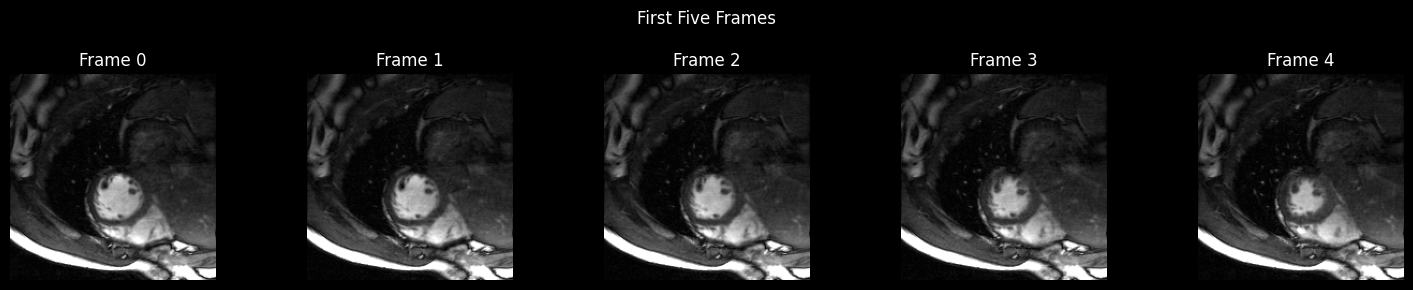

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 加载数据
data = np.load('/nfs/zzy/code/k_gin_base/output/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 选择数据的一个切片
# data = data[100:101, :, :, :]
data = data[0:1, :, :, :]

# 假设 IFFT2c 是一个函数，用于计算逆傅里叶变换
# 由于代码中没有提供 IFFT2c 函数的定义，这里假设它已经定义好了
img = IFFT2c(data)
img = img[0]
print("img:", img.shape)

# 归一化并增强亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# 创建一个图像网格来显示前五张图片
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # 1行5列的子图
fig.suptitle('First Five Frames')  # 设置总标题

# 遍历前五张图片并显示在子图中
for i in range(5):
    axs[i].imshow(img_brightened[i], cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')  # 关闭坐标轴

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以避免标题重叠
plt.show()
